Libraries

In [1018]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import geopandas as gpd
import plotly.express as px

Styles

In [1019]:
pd.options.mode.chained_assignment = None

In [1020]:
plt.rcParams.update({'font.family':'Arial'})

In [1021]:
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

In [1022]:
%matplotlib inline

In [1023]:
plt.rcParams['figure.figsize'] = (20,10)

In [1024]:
saved_style_state = matplotlib.rcParams.copy()

In [1025]:
pd.set_option('display.max_rows', None)

Reading files...

In [1026]:
ev = pd.read_csv("IEA-EV-data.csv")

In [1027]:
country = pd.read_csv("countries.csv")

In [1028]:
energy = pd.read_csv("energy.csv")

In [1029]:
renewable_share = pd.read_csv("renewable-share-energy.csv")

Cleaning file

In [1030]:
world_geo = pd.read_csv("world_geo.csv")

world_geo = world_geo.rename({'gdp_md_est': 'sales'}, axis=1)

world_geo = world_geo[(world_geo.name != 'Antarctica')]

world_geo = world_geo.drop('Unnamed: 0', axis=1)

world_geo = world_geo.replace(0, np.nan)

world_geo = world_geo.sort_values(['name'])

items_geo = []

for c in world_geo.name:
    items_geo.append(c)

items_geo.pop()

items_geo.pop()

l = len(items_geo)

world_map = world_geo

Choropleth map (total electric vehicle sales)

In [1031]:
fig = px.choropleth(world_map,
    locations = 'iso_a3',
    height = 750,
    color = 'sales',
    title = 'Total Electric Vehicle Sales',
    range_color = [0, 1000000],
    color_continuous_scale = 'Greens',
    
)


fig.show()

Latest sales share

In [1032]:
def sales_share_latest(country):
    s = ev[(ev.region == country) & (ev.parameter == 'EV sales share') & (ev.category == 'Historical') & (ev['mode'] == 'Cars')]

    last = s.iloc[-1].value

    return last

Earliest sales share

In [1033]:
def sales_share_earliest(country):
    s = ev[(ev.region == country) & (ev.parameter == 'EV sales share') & (ev.category == 'Historical') & (ev['mode'] == 'Cars')]

    first = s.iloc[-2].value

    return first

List of all recorded countries

In [1034]:
country_list = []

for c in ev.region:
    if c not in country_list:
        country_list.append(c)

country_list.remove('World')
country_list.remove('Europe')
country_list.remove('Rest of the world')
country_list.remove('Other Europe')
country_list.remove('Indonesia')
country_list.remove('Thailand')

country_list[15] = 'South Korea'

country_list = sorted(country_list)

country_list[-1] = country_list[-2]
country_list[-2] = 'United Kingdom'


Sales Share Lists

In [1035]:
shares_latest = []
for c in country_list:
    if c == 'South Korea':
        shares_latest.append(f"{sales_share_latest('Korea')}")
    else:
        shares_latest.append(f"{sales_share_latest(c)}")

shares_earliest = []
for c in country_list:
    if c == 'South Korea':
        shares_earliest.append(f"{sales_share_earliest('Korea')}")
    else:
        shares_earliest.append(f"{sales_share_earliest(c)}")


shares_latest = list(map(float, shares_latest))
shares_earliest = list(map(float, shares_earliest))


l = len(shares_latest)
l2 = len(shares_earliest)


New Dataframe

In [1036]:
df = pd.DataFrame({'2021': shares_latest})
df1 = pd.DataFrame({'2020': shares_earliest})
df2 = pd.DataFrame({'country': country_list})

all_shares = pd.concat([df2, df1, df], axis=1)

all_shares = all_shares.sort_values('2021')


Bar plot

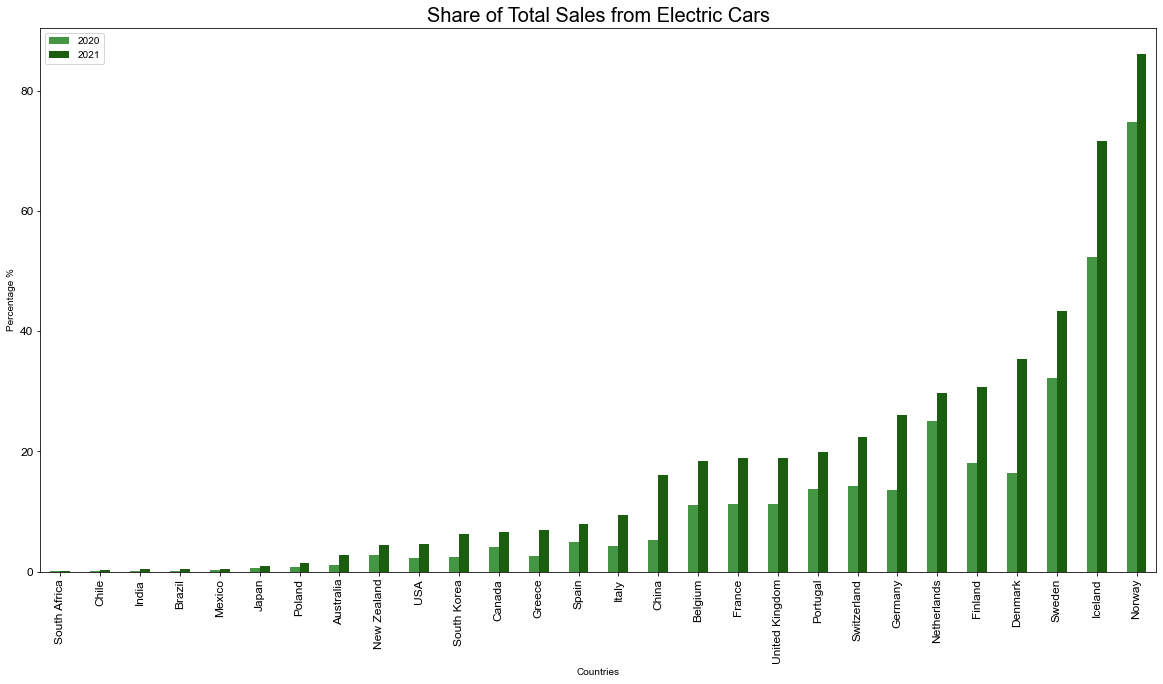

In [1037]:

all_shares.plot(kind = 'bar', 
x = 'country', 
stacked = False,
xlabel = 'Countries',
ylabel = 'Percentage %',
fontsize = '12',
color = {'2020': '#449644','2021': '#1b5e0f'}
)

plt.title('Share of Total Sales from Electric Cars', fontsize=20)

plt.show()

Changing values in dataset

In [1038]:
world_share = world_geo

world_share = world_share.sort_values('name')

world_share = world_share.rename(columns = {'sales': 'percentage %'})

In [1039]:
total_sales = []

for i in world_share['percentage %']:
    if i > 0:
        total_sales.append(i)

In [1040]:
world_share['percentage %'].replace(to_replace = total_sales, value = shares_latest, inplace = True)


Choropleth for ev sales share

In [1041]:
fig2 = px.choropleth(world_share,
    locations = 'iso_a3',
    height = 750,
    color = 'percentage %',
    title = 'Share of Total Sales from Electric Cars',
    range_color = [0,90],
    color_continuous_scale = 'Greens',
    
)


fig2.show()

Investigating energy data

In [1042]:
energy = energy.dropna(axis=1, how='all')

Investigating renewable share data 

In [1043]:
is_21 = renewable_share.Year == 2021

share_21 = renewable_share[is_21]

share_21 = share_21.reset_index()

share_21 = share_21.drop('index', axis=1)



def get_2021(c):
    for i in range(len(share_21.Entity)):
        if share_21.Entity[i] == c:
            a = share_21['Renewables (% equivalent primary energy)'][i]

    #r = pd.DataFrame([a], columns=[c])

    return a


In [1044]:
is_00 = renewable_share.Year == 2000

share_00 = renewable_share[is_00]

share_00 = share_00.reset_index()

share_00 = share_00.drop('index', axis=1)

def get_2000(c):
    for i in range(len(share_00.Entity)):
        if share_00.Entity[i] == c:
            a = share_00['Renewables (% equivalent primary energy)'][i]

    #r = pd.DataFrame([a], columns=[c])

    return a

In [1045]:
k = get_2000('Iceland')
w = get_2000('World')
e = get_2000('Europe')
af = get_2000('Africa')
a = get_2000('Asia')
ap = get_2000('Asia Pacific (BP)')
t = get_2000('Trinidad and Tobago')
au = get_2000('Australia')
o = get_2000('Oceania')

to_2000 = [af, a, ap, au, w, e, o]

countries = ['Africa', 'Asia', 'Asia Pacific (BP)', 'Australia', 'World', 'Europe', 'Oceania']

In [1046]:
sorted_21 = share_21.sort_values(by=['Renewables (% equivalent primary energy)'])

In [1047]:
ksi = get_2021('Iceland')
wor = get_2021('World')
eur = get_2021('Europe')
afr = get_2021('Africa')
asi = get_2021('Asia')
asp = get_2021('Asia Pacific (BP)')
tnt = get_2021('Trinidad and Tobago')
aus = get_2021('Australia')
oce = get_2021('Oceania')

to_2021 = [afr, asi, asp, aus, wor, eur, oce]

countries = ['Africa', 'Asia', 'Asia Pacific (BP)', 'Australia', 'World', 'Europe', 'Oceania']


In [1048]:
lowest = 0
entity = []
for i in share_21.Entity:
    r = get_2021(i)
    if lowest < r < 25:
        lowest = r
        entity.append(i)

print(f"{lowest}, {entity[-1]}")


highest = 0
ent = []
for j in share_21.Entity:
     k = get_2021(j)
     if k > highest:
        highest = k
        ent.append(j)

print(f"{highest}, {ent[-1]}")

23.91737174987793, Latvia
86.8745346069336, Iceland


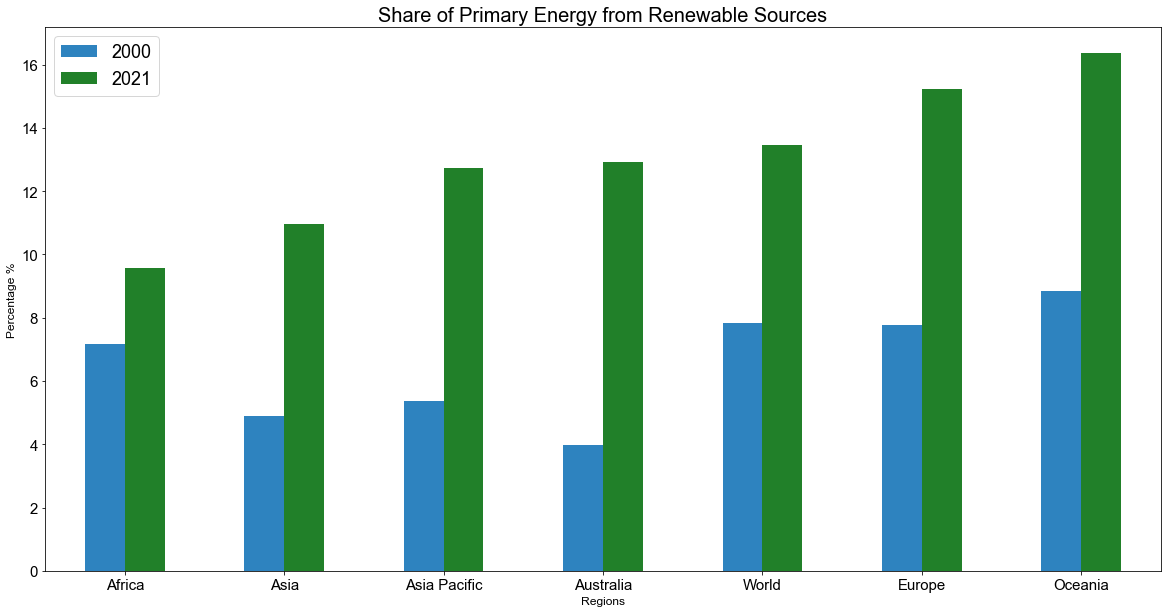

In [1053]:
index = ['Africa', 'Asia', 'Asia Pacific', 'Australia', 'World', 'Europe', 'Oceania']

comp_00_21 = pd.DataFrame({'2000': to_2000,
                   '2021': to_2021}, index=index)

ax = comp_00_21.plot.bar(rot=0, color={'2000': '#2e83bf', '2021': '#218029'})

plt.title('Share of Primary Energy from Renewable Sources', fontsize=20)

plt.legend(prop={'size':18})

plt.xlabel('Regions', fontsize=12)
plt.ylabel('Percentage %', fontsize=12)

plt.show()

In [1050]:
def is_country(country):
    r = renewable_share.Entity == country
    ren = renewable_share[r]
    lst = list(ren['Renewables (% equivalent primary energy)'])
    df = pd.DataFrame(lst, columns=[country])
    return df

In [1051]:
period = list(range(1965,2022))

aus = is_country('Australia')

nor = is_country('Norway')

usa = is_country('United States')

nzl = is_country('New Zealand')

fin = is_country('Finland')

can = is_country('Canada')

swe = is_country('Sweden')

chi = is_country('China')

ice = is_country('Iceland')

zaf = is_country('South Africa')

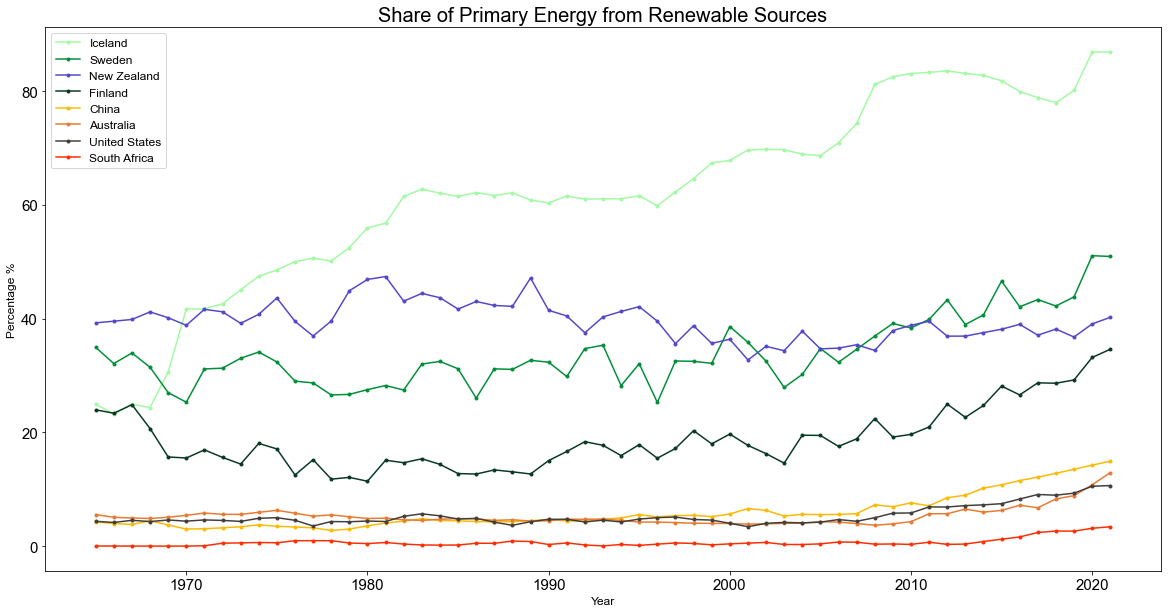

In [1055]:
renewable = pd.DataFrame(period, columns=['Year'])


com_ren = pd.concat([renewable, aus, nor, usa, nzl, fin, can, swe, chi, ice, zaf], axis=1)



plt.title('Share of Primary Energy from Renewable Sources', fontsize=20)
plt.plot(com_ren.Year, com_ren.Iceland, '.-', color='#A2FAA3', label='Iceland')
plt.plot(com_ren.Year, com_ren.Sweden, '.-', color='#008F39', label='Sweden')
plt.plot(com_ren.Year, com_ren['New Zealand'], '.-', color='#5448C8', label='New Zealand')
plt.plot(com_ren.Year, com_ren.Finland, '.-', color='#093824', label='Finland')
plt.plot(com_ren.Year,com_ren.China, '.-', color='#fcba03', label='China')
plt.plot(com_ren.Year, com_ren.Australia, '.-', color='#e87b31', label='Australia')
plt.plot(com_ren.Year, com_ren['United States'], '.-', color='#423E3B', label='United States')
plt.plot(com_ren.Year, com_ren['South Africa'], '.-', color='#FF2E00', label='South Africa')

plt.xlabel('Year', fontsize=12)

plt.ylabel('Percentage %', fontsize=12)

plt.legend(loc='upper left', prop={'size':12})


plt.show()